<a href="https://colab.research.google.com/github/ciro-greco/AI-engineering-IEOR4574E001/blob/main/week_3_LLMOPs_API_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 — LLM API Playground
This script mirrors Slides 1–11 and can be pasted into a notebook.
It uses a free model (TinyLlama) so students don’t need paid credits.


## Setup
If needed, install deps (uncomment when running in a fresh env):

In [ ]:
# !pip install -U transformers accelerate torch huggingface_hub

In [ ]:
import os, time, math, random, uuid
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TextIteratorStreamer,  # yields partial tokens as they are produced (streaming)
)

# ---------------------------
# Model choice and device selection
# ---------------------------
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # free + small + chat-tuned
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------------------------
# Load tokenizer and model
# ---------------------------
# torch_dtype:
#   - fp16 on GPU saves memory/bandwidth, faster
#   - fp32 on CPU to avoid precision issues on machines without AVX/AMP
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True,  # reduce RAM peak during load
).to(device)
model.eval()  # we only do inference in this playground
print(f"Loaded {MODEL_ID} on {device}")

Device: cpu
Loaded TinyLlama/TinyLlama-1.1B-Chat-v1.0 on cpu


## Anatomy of a Request

We mimic a “chat completion” payload you would send to a provider API:
- model: model identifier (or version pin)
- messages: [{"role": "system"|"user"|"assistant", "content": "..."}]
- sampling knobs: temperature, top_p, max_new_tokens, stop
- metadata: user_id, idempotency_key (for safe retries), etc.


In [ ]:
def build_chat_request(
    system: str,
    user: str,
    temperature: float = 0.7,
    top_p: float = 0.9,
    max_new_tokens: int = 128,
    stop: Optional[List[str]] = None,
) -> Dict[str, Any]:
    """
    Build a simple chat-style request payload.
    In production, you'd also include tenant info, analytics tags, etc.
    """
    return {
        "model": MODEL_ID,
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ],
        "temperature": temperature,        # controls randomness (higher => more diverse)
        "top_p": top_p,                    # nucleus sampling cap (probability mass)
        "max_new_tokens": max_new_tokens,  # hard cap on output length (cost/latency guardrail)
        "stop": stop or [],                # optional stop sequences to cut off generations
        "user_id": "student123",           # example tenancy/analytics tag
        "idempotency_key": f"req-{uuid.uuid4()}",  # retry-safe identifier
    }

req = build_chat_request(
    system="You are a helpful teaching assistant.",
    user="Explain tokenization to a new student in two sentences.",
)
print("Example request:", req)

# ---------------------------
# Minimal message formatter for a causal LM
# ---------------------------
def format_messages_for_causal_lm(messages: List[Dict[str, str]]) -> str:
    """
    Very simple “chat” formatter for a causal LM.
    Many chat models ship a tokenizer.chat_template — use that in production.
    Here we just tag SYSTEM/USER/ASSISTANT for clarity.
    """
    sys_msg = next((m["content"] for m in messages if m["role"] == "system"), "")
    user_msg = next((m["content"] for m in messages if m["role"] == "user"), "")
    return f"[SYSTEM]\n{sys_msg}\n[USER]\n{user_msg}\n[ASSISTANT]\n"


Example request: {'model': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'messages': [{'role': 'system', 'content': 'You are a helpful teaching assistant.'}, {'role': 'user', 'content': 'Explain tokenization to a new student in two sentences.'}], 'temperature': 0.7, 'top_p': 0.9, 'max_new_tokens': 128, 'stop': [], 'user_id': 'student123', 'idempotency_key': 'req-4d474061-b9ee-4268-aeca-3f6ca93d23f7'}


# Non-streaming generation

generate_blocking():
- Builds the prompt
- Calls model.generate()
- Returns the full text once finished
This mirrors a non-streaming HTTP response: you get everything at once.

In [ ]:
def generate_blocking(request: Dict[str, Any]) -> str:
    prompt = format_messages_for_causal_lm(request["messages"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # do_sample=True enables sampling (temperature/top_p take effect)
    out = model.generate(
        **inputs,
        max_new_tokens=request["max_new_tokens"],
        do_sample=True,
        temperature=request["temperature"],
        top_p=request["top_p"],
        eos_token_id=tokenizer.eos_token_id,  # stop at EOS if encountered
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)

    # Split off our “[ASSISTANT]” tag for cleaner display.
    return text.split("[ASSISTANT]\n", 1)[-1]

blocking_text = generate_blocking(req)
print("\n--- Non-streaming output ---\n", blocking_text)

NameError: name 'Dict' is not defined

# Streaming demo + TTFT / TPOT measurement

Streaming:
Students see partial tokens arrive (improves perceived latency)
We measure:
- TTFT (Time-to-First-Token): time from request start to first yielded token
- TPOT (tokens/sec): decode rate after the first token

In [ ]:
from threading import Thread

def stream_with_metrics(request: Dict[str, Any]) -> Dict[str, Any]:
    """
    Stream tokens using TextIteratorStreamer and compute:
      - TTFT (ms): how long until first token appears
      - tokens_per_sec (TPOT): average token rate during decode
    """
    prompt = format_messages_for_causal_lm(request["messages"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Streamer converts the token IDs from generate() into text chunks on the fly.
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    gen_kwargs = dict(
        **inputs,
        max_new_tokens=request["max_new_tokens"],
        do_sample=True,
        temperature=request["temperature"],
        top_p=request["top_p"],
        eos_token_id=tokenizer.eos_token_id,
        streamer=streamer,  # attach streamer to generation
    )

    # Run generation in a background thread so we can iterate streamer in the foreground.
    start = time.time()
    thread = Thread(target=model.generate, kwargs=gen_kwargs)
    thread.start()

    pieces = []             # collected text chunks
    first_token_time = None # record timestamp of the *first* streamed token
    token_count = 0         # count how many tokens we streamed

    for token_text in streamer:
        pieces.append(token_text)
        token_count += 1
        if first_token_time is None:
            # First chunk arrived: compute TTFT (ms)
            first_token_time = time.time()
            ttft_ms = (first_token_time - start) * 1000
            print(f"\n[TTFT] {ttft_ms:.1f} ms — first token arrived\n")
        # Show streamed text progressively (like a chat UI typing)
        print(token_text, end="", flush=True)

    # Decode phase ended: compute tokens/sec
    end = time.time()
    total_decode_time = end - (first_token_time or start)
    tokens_per_sec = (token_count / total_decode_time) if token_count > 0 and total_decode_time > 0 else float("nan")

    return {
        "text": "".join(pieces),
        "ttft_ms": (first_token_time - start) * 1000 if first_token_time else None,
        "tokens": token_count,
        "tokens_per_sec": tokens_per_sec,     # TPOT (higher is faster)
        "elapsed_decode_s": total_decode_time # how long the decode phase lasted
    }

stream_metrics = stream_with_metrics(
    build_chat_request(
        system="You are a helpful teaching assistant.",
        user="List three practical tips to speed up TTFT and TPOT in an LLM service.",
        max_new_tokens=120,
    )
)
print("\n\n[Stream metrics]", stream_metrics)


[TTFT] 2210.3 ms — first token arrived

1. Use the TPOT function: This function allows you to perform a prediction using a pre-trained model, which can be useful when the TTFT model is not available.
2. Use the TTFT function: This function can be used to predict a target variable based on the features provided.
3. Use the TPOT function: This function allows you to create a custom TPOT model from scratch.
Here are some practical tips to speed up TTFT and TPOT in an LLM service:

1. Use the TP

[Stream metrics] {'text': '1. Use the TPOT function: This function allows you to perform a prediction using a pre-trained model, which can be useful when the TTFT model is not available.\n2. Use the TTFT function: This function can be used to predict a target variable based on the features provided.\n3. Use the TPOT function: This function allows you to create a custom TPOT model from scratch.\nHere are some practical tips to speed up TTFT and TPOT in an LLM service:\n\n1. Use the TP', 'ttft_ms':

# Rate limits & retries with backoff

In production, you’ll face:
- 429 (rate limited) → back off and retry
- 5xx (provider/server errors) → retry with capped attempts
We simulate these with a simple token-bucket + exceptions.

In [ ]:
@dataclass
class TokenBucket:
    capacity: int      # maximum tokens bucket can hold (burst size)
    fill_rate: float   # tokens per second refilled
    tokens: float = 0.0
    last: float = time.time()

    def allow(self, cost: int = 1) -> bool:
        """Return True if a request can be allowed now, else False (simulate 429)."""
        now = time.time()
        # refill based on elapsed time
        self.tokens = min(self.capacity, self.tokens + (now - self.last) * self.fill_rate)
        self.last = now
        if self.tokens >= cost:
            self.tokens -= cost
            return True
        return False

class RateLimitedError(Exception):
    """Simulates HTTP 429 errors."""
    pass

class ServerError(Exception):
    """Simulates transient 5xx server errors."""
    pass

def backoff(attempt: int, base_ms: int = 200, cap_ms: int = 4000, jitter: bool = True) -> float:
    """
    Exponential backoff with optional jitter:
    attempt=0 -> ~200ms, 1 -> ~400ms, 2 -> ~800ms ... (capped at 4000ms).
    """
    ms = min(cap_ms, base_ms * (2 ** attempt))
    if jitter:
        ms *= random.uniform(0.5, 1.5)
    return ms / 1000.0

# Token bucket allows ~1.5 req/sec with bursts up to 5.
bucket = TokenBucket(capacity=5, fill_rate=1.5)

def robust_stream_call(request: Dict[str, Any], max_retries: int = 3) -> Dict[str, Any]:
    """
    Wrap stream_with_metrics() with:
      - local rate limiting (token bucket)
      - retry on 429 (simulate) and 5xx (simulate)
      - exponential backoff + jitter
    """
    for attempt in range(max_retries + 1):
        # 429 simulation via token bucket
        if not bucket.allow():
            if attempt == max_retries:
                raise RateLimitedError("Too many requests; out of retries")
            sleep_s = backoff(attempt)
            print(f"[429] Rate-limited. Backing off for {sleep_s:.2f}s…")
            time.sleep(sleep_s)
            continue

        try:
            # Randomly simulate a transient server error 10% of the time
            if random.random() < 0.1:
                raise ServerError("Transient server error")
            return stream_with_metrics(request)

        except ServerError as e:
            # On 5xx: retry with backoff, up to max_retries
            if attempt == max_retries:
                raise
            sleep_s = backoff(attempt)
            print(f"[5xx] {e}. Retrying in {sleep_s:.2f}s…")
            time.sleep(sleep_s)

# Try a robust call that may hit backoff logic.
robust_metrics = robust_stream_call(
    build_chat_request(
        system="You are a helpful teaching assistant.",
        user="Explain rate limiting and retries to a class of undergrads.",
        max_new_tokens=80,
    )
)
print("\n\n[Robust call metrics]", robust_metrics)

[429] Rate-limited. Backing off for 0.14s…
[429] Rate-limited. Backing off for 0.21s…
[429] Rate-limited. Backing off for 0.50s…

[TTFT] 1898.6 ms — first token arrived

Rate limiting is a technique that limits the number of requests that can be made to a server per specified time period. This can be used to prevent overloading the server and reduce the likelihood of a request being rejected due to a server being too busy. Rate limiting can be used in a number of different scenarios, such as when a user is trying to access a website, or when

[Robust call metrics] {'text': 'Rate limiting is a technique that limits the number of requests that can be made to a server per specified time period. This can be used to prevent overloading the server and reduce the likelihood of a request being rejected due to a server being too busy. Rate limiting can be used in a number of different scenarios, such as when a user is trying to access a website, or when', 'ttft_ms': 1898.58078956604, 'tokens': 

# Observability — simple per-request logs + quick charts

We’ll keep a list of dicts and convert to a DataFrame.
In production, push to Prometheus/Grafana/ELK, etc.


[TTFT] 1650.0 ms — first token arrived

Sure, here are three ideas for a CS class project:
1. Virtual Reality Simulation: Create a VR simulation that allows students to explore a virtual world or experience a virtual environment. This project requires programming skills and a virtual reality headset.
2. Robotics and Artificial Intelligence: Build a robot that can perform tasks such as sorting, shuffling
[TTFT] 2299.6 ms — first token arrived

Sure!

TTFT stands for Tensor Train Frequency Transfer, which is a technique used in the design of radar systems. TTFT involves combining multiple antenna signals with a single transmitter signal to create a signal that is both stronger and more directional than the original signals.

On the other hand, TPOT (Time-Proportional Orthogonal Pol
[TTFT] 1628.1 ms — first token arrived

1. Use the `debug` command:
  ```
  > debug [your-lm-name]
  ```
  This will enable debugging on the LM.

  You can then set breakpoints in the code to trace through th

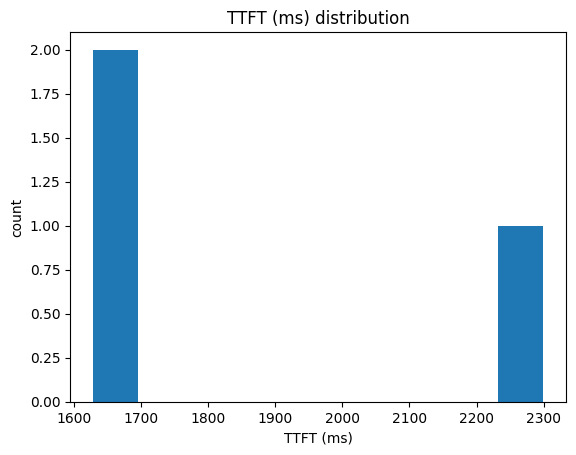

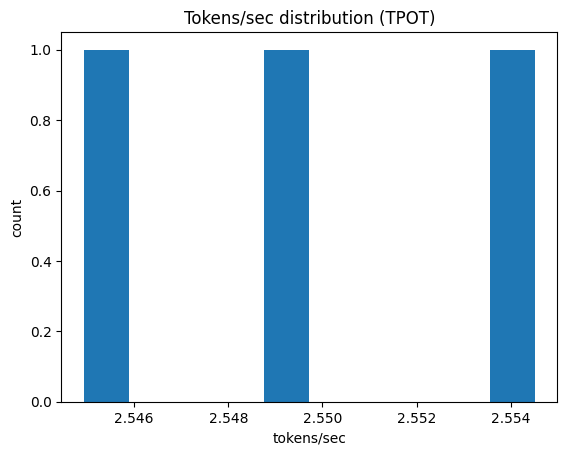

In [ ]:
import pandas as pd
from time import time as now

logs: List[Dict[str, Any]] = []

def log_request(req: Dict[str, Any], metrics: Dict[str, Any], http_code: int = 200):
    """
    Capture minimal observability fields.
    Add more fields as needed (provider latency, error codes, RAG timing, etc.).
    """
    entry = {
        "ts": now(),
        "user": req.get("user_id"),
        "ttft_ms": metrics.get("ttft_ms"),
        "tokens": metrics.get("tokens"),
        "tokens_per_sec": metrics.get("tokens_per_sec"),
        "http_code": http_code,
        "idempotency_key": req.get("idempotency_key"),
        "prompt_chars": sum(len(m.get("content", "")) for m in req.get("messages", [])),
        "temperature": req.get("temperature"),
        "top_p": req.get("top_p"),
        "max_new_tokens": req.get("max_new_tokens"),
    }
    logs.append(entry)

# Generate a few requests to populate logs
for q in [
    "Give me three ideas for a CS class project.",
    "Explain the difference between TTFT and TPOT.",
    "List 5 tips to debug slow LLM responses.",
]:
    r = build_chat_request("You are helpful.", q, max_new_tokens=80)
    m = robust_stream_call(r)
    log_request(r, m, 200)

df = pd.DataFrame(logs)
print("\n\n[Latest logs]\n", df.tail())

# ---------------------------
# Quick visualizations (matplotlib)
# ---------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["ttft_ms"].dropna(), bins=10)
plt.title("TTFT (ms) distribution")
plt.xlabel("TTFT (ms)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(df["tokens_per_sec"].dropna(), bins=10)
plt.title("Tokens/sec distribution (TPOT)")
plt.xlabel("tokens/sec")
plt.ylabel("count")
plt.show()

# End-to-end request lifecycle (textual simulation)

We mirror your “End to end request lifecycle” slide:
- AuthN/AuthZ → Validate → Prompt assembly → (Optional) RAG → Call model (start streaming) → Post-process → Return stream → Persist logs → On error retry/fallback → Monitor


In [ ]:
def end_to_end_simulation(user_text: str):
    print("1) AuthN/AuthZ — (skipped in this local demo)\n")
    print("2) Validate & sanitize input — (assume OK)\n")
    print("3) Prompt assembly — build messages & template\n")
    req = build_chat_request("You are helpful.", user_text, max_new_tokens=80)
    print(req, "\n")

    print("4) (Optional) RAG fetch — (skipped in this notebook)\n")
    print("5) Call model (start streaming) — measuring TTFT\n")
    metrics = stream_with_metrics(req)

    print("\n6) Post-process (format/guardrails) — (skipped here)\n")
    print("7) Return stream — already printing chunks above\n")
    print("8) Persist logs/metrics — logging one entry now\n")
    log_request(req, metrics, 200)

    print("9) On error: retry/backoff/fallback — handled in robust_stream_call() earlier\n")
    print("10) Monitor dashboards & alerts — visualize from df later\n")
    return metrics

_ = end_to_end_simulation("What is a reasonable default for temperature and top_p in sampling?")

print("\nDone. You now have a minimal, fully-instrumented LLM API playground using a free HF model.")


1) AuthN/AuthZ — (skipped in this local demo)

2) Validate & sanitize input — (assume OK)

3) Prompt assembly — build messages & template

{'model': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0', 'messages': [{'role': 'system', 'content': 'You are helpful.'}, {'role': 'user', 'content': 'What is a reasonable default for temperature and top_p in sampling?'}], 'temperature': 0.7, 'top_p': 0.9, 'max_new_tokens': 80, 'stop': [], 'user_id': 'student123', 'idempotency_key': 'req-84cbe5db-5548-41d7-acdf-b0093a6ab54d'} 

4) (Optional) RAG fetch — (skipped in this notebook)

5) Call model (start streaming) — measuring TTFT


[TTFT] 1733.9 ms — first token arrived

For temperature, a reasonable default is 298.15 Kelvin (25°C). For top_p, a reasonable default is 1.0.
6) Post-process (format/guardrails) — (skipped here)

7) Return stream — already printing chunks above

8) Persist logs/metrics — logging one entry now

9) On error: retry/backoff/fallback — handled in robust_stream_call() earlier

10) Monito